# Image classification of dataset CIFAR-10

### Import libraries, import dataset
Dataset is already split in train and testing parts, we need to create validation part and save all labels as categories

In [7]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import datetime
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [8]:
# Split training data into training and validation sets
num_validation_samples = int(0.2 * X_train.shape[0])  # 20% of the training dataset (40k:10k)

X_val = X_train[:num_validation_samples]
y_val = y_train[:num_validation_samples]

X_train = X_train[num_validation_samples:]
y_train = y_train[num_validation_samples:]


y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)


### Preprocessing of train, validation and test datasets
Preprocessing steps taken are: 
- shuffling of the training instances
- dividing into batches for faster training
- optimizing the pipeline according to the hardware to speed up training

During training of the network, some images are flipped horizontally, rotated or zoomed in to increase the variability of the training set

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 180
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


train_dataset = (
    train_dataset
    .shuffle(10000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

validation_dataset = (
    val_dataset
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_dataset = (
    test_dataset
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

### CNN architecture
Steps and layers:
1. augmentation of random pictures
2. rescaling of all pictures to range (0,1)
3. convolutional filters are applied with "relu" activation function (it is most widely used function in CNN) and symmetrical padding from all sides
4. normalization in batches
5. max pooling layers to summarize the most prominent features 

#### Experiment:
Four types of optimizers were tested, "adamw" turned out to be the best. "sgd" got worse results, then "adam" and "adagrad". The difference between best and worst reached up to 20 pp.


In [11]:
inputs = keras.Input(shape=(32, 32, 3))

x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)


x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
model.summary()

model.compile(loss="categorical_crossentropy",
              optimizer="adamw",
              metrics=["accuracy"])
!rm -rf ./logs/

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 316,682 (1.21 MB)

 Trainable params: 315,786 (1.20 MB)

 Non-trainable params: 896 (3.50 KB)

'rm' is not recognized as an internal or external command,
operable program or batch file.


### Model training

In [12]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta = 0.002, restore_best_weights=True)
# dataset augmentation can cause higher volatility, it needs more patience, 10 patience 80% accuracy, 10 patience 90% accuracy

history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=[callback, tensorboard_callback])

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.3049 - loss: 2.0030 - val_accuracy: 0.3875 - val_loss: 1.6713
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.4647 - loss: 1.4876 - val_accuracy: 0.5484 - val_loss: 1.2472
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5146 - loss: 1.3669 - val_accuracy: 0.5915 - val_loss: 1.1408
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5545 - loss: 1.2611 - val_accuracy: 0.5913 - val_loss: 1.1302
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5840 - loss: 1.1886 - val_accuracy: 0.5397 - val_loss: 1.3990
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6080 - loss: 1.1269 - val_accuracy: 0.6780 - val_loss: 0.9130
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6264 - loss: 1.0860 - val_accuracy: 0.5984 - val_loss: 1.1682
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.6396 -

### Evaluation

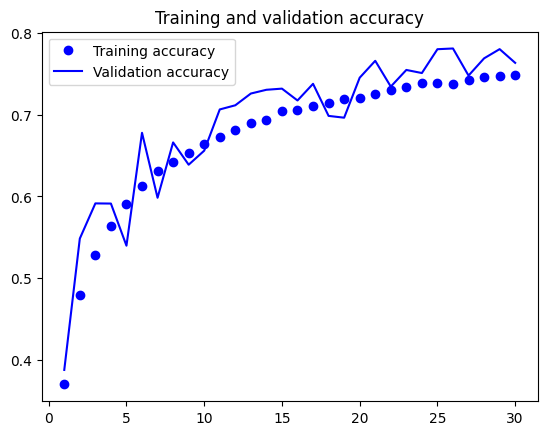

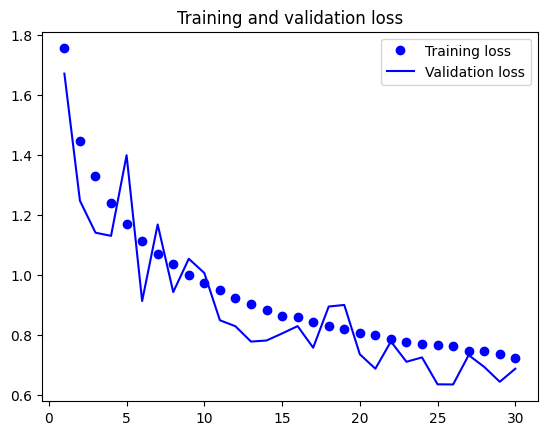

In [13]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [14]:
test_loss, test_acc = model.evaluate(test_dataset)
print("Test accuracy: is", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7691 - loss: 0.6600
Test accuracy: is 0.7685999870300293


In [16]:
batch_size = 10
img_height, img_width = 32, 32

test2 = tf.keras.utils.image_dataset_from_directory(
    'test2',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode=None
)

Found 10 files.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Image 0:
  Class 0: Probability = 0.0765
  Class 1: Probability = 1.0000
  Class 2: Probability = 0.0025
  Class 3: Probability = 0.0037
  Class 4: Probability = 0.0001
  Class 5: Probability = 0.0002
  Class 6: Probability = 0.0003
  Class 7: Probability = 0.0000
  Class 8: Probability = 0.2638
  Class 9: Probability = 0.9947
Image 1:
  Class 0: Probability = 0.0765
  Class 1: Probability = 1.0000
  Class 2: Probability = 0.0025
  Class 3: Probability = 0.0037
  Class 4: Probability = 0.0001
  Class 5: Probability = 0.0002
  Class 6: Probability = 0.0003
  Class 7: Probability = 0.0000
  Class 8: Probability = 0.2638
  Class 9: Probability = 0.9947
Image 2:
  Class 0: Probability = 0.0051
  Class 1: Probability = 0.0011
  Class 2: Probability = 0.4347
  Class 3: Probability = 0.1649
  Class 4: Probability = 0.9974
  Class 5: Probability = 0.3365
  Class 6: Probability = 0.8544
  Class 7: Probability = 0.4821
  Class 8: Probability = 0.0003
  Class

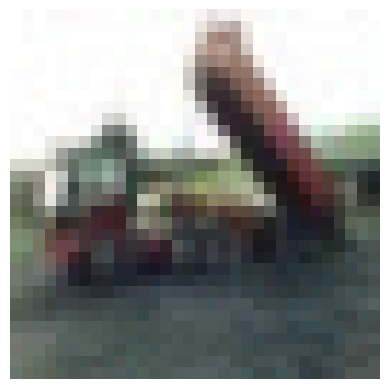

1


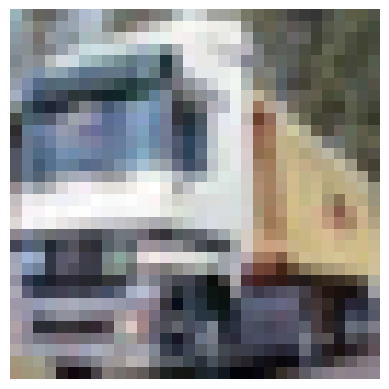

2


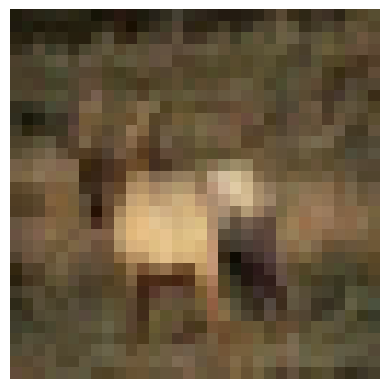

3


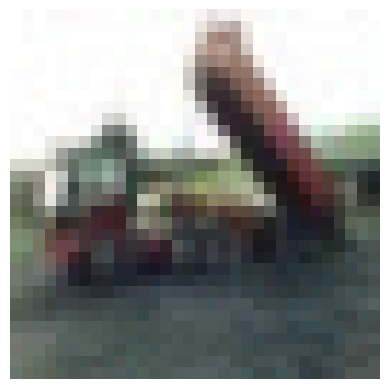

4


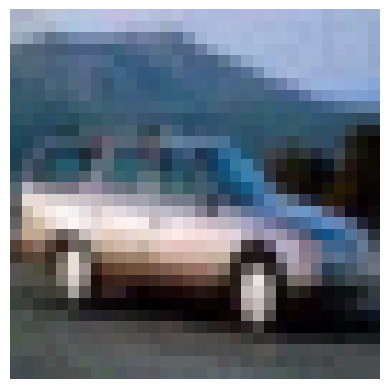

5


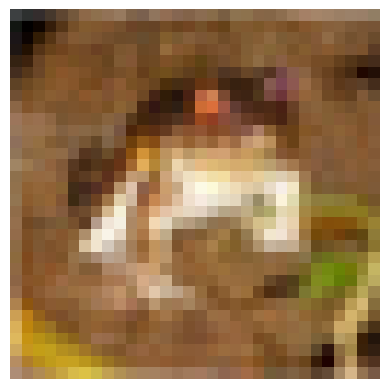

6


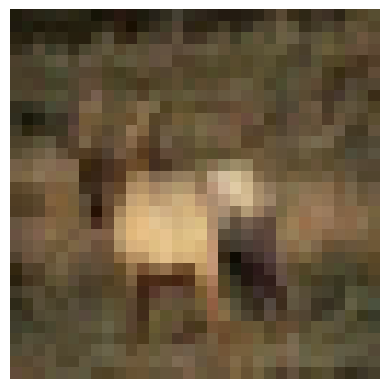

7


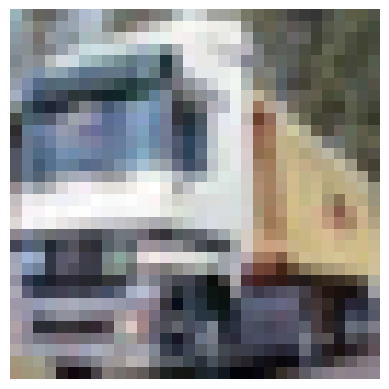

8


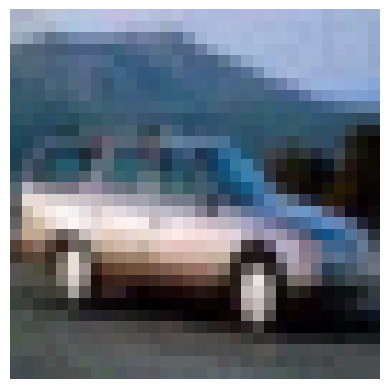

9


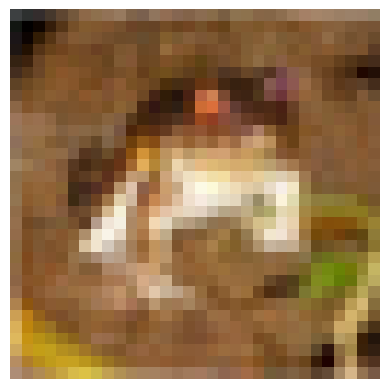

In [25]:
# Make predictions
predictions = model.predict(test2)
for i, pred in enumerate(predictions):
    print(f"Image {i}:")
    for class_index, prob in enumerate(pred):
        print(f"  Class {class_index}: Probability = {prob:.4f}")

#printing an image
for images in test2:
    for i, image in enumerate(images):
        print(i)
        image = image / 255.0
        image_np = image.numpy()

        # Display the image
        plt.imshow(image_np)
        plt.axis('off')  # Turn off axis labels
        plt.show()

The accuracy of the model on these 10 images is 2/10, which does not correspond with the accuracy on the training nor testing set. This can be caused by choice of the testing images as the model can be very good at recognising other categories but not automobiles, deer, frogs and trucks.